In [1]:
import pandas as pd

# Carga el DataFrame con tus datos
data = pd.read_csv('machine_learning.csv')  # Asegúrate de cambiar el nombre del archivo

# Filtra las reseñas con calificaciones de 4 y 5 estrellas
positive_reviews = data[data['rating'].isin([4, 5])]

# Mantén solo las columnas relevantes
relevant_columns = ['rating', 'text']
positive_reviews = positive_reviews[relevant_columns]

# Muestra las primeras filas del DataFrame resultante
print(positive_reviews.head())

   rating                                               text
1       5  This is my first time at this first watch\nThe...
2       4  After a 5 hour red-eye flight, I just wanted t...
4       5  The Italian food actually tastes Italian and n...
5       5  Small place, with a dining area tucked back be...
6       5  Delicious!! We got ramen bowl and a rice dish,...


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   author_name                 295 non-null    object 
 1   author_url                  295 non-null    object 
 2   language                    295 non-null    object 
 3   original_language           295 non-null    object 
 4   profile_photo_url           295 non-null    object 
 5   rating                      500 non-null    int64  
 6   relative_time_description   295 non-null    object 
 7   text                        500 non-null    object 
 8   time                        295 non-null    float64
 9   translated                  295 non-null    object 
 10  restaurant_name             500 non-null    object 
 11  restaurant_location         500 non-null    object 
 12  city                        500 non-null    object 
 13  gmap_id                     500 non

**Procesamiento de texto**

In [2]:
from transformers import BertTokenizer
import re

# Crea un objeto de tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Función para preprocesar y tokenizar una reseña
def preprocess_and_tokenize(text):
    # Elimina caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convierte el texto a minúsculas
    text = text.lower()
    # Tokeniza el texto utilizando el tokenizador BERT
    tokens = tokenizer.tokenize(text)
    return tokens

# Ejemplo de reseña
review_example = "El restaurante tiene una comida deliciosa y un servicio increíble."

# Preprocesa y tokeniza la reseña de ejemplo
tokens = preprocess_and_tokenize(review_example)

print(tokens)

c:\Users\Juli\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['el', 'restaurant', '##e', 'tie', '##ne', 'una', 'com', '##ida', 'del', '##icio', '##sa', 'y', 'un', 'ser', '##vic', '##io', 'inc', '##re', '##ble']


**Carga del modelo BERT preentrenado**

In [3]:
from transformers import BertModel

# Carga el modelo BERT preentrenado
model = BertModel.from_pretrained('bert-base-uncased')

# Muestra información del modelo
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

**Extracción de características**

In [4]:
import torch
from transformers import BertTokenizer, BertModel

# Crea un objeto de tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Crea un objeto del modelo BERT preentrenado
model = BertModel.from_pretrained('bert-base-uncased')

# Función para obtener las representaciones de palabras
def extract_word_embeddings(tokens):
    # Codifica los tokens y obtiene las representaciones de las palabras
    inputs = tokenizer(tokens, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    word_embeddings = outputs.last_hidden_state
    return word_embeddings

# Ejemplo de reseña
review_example = "El restaurante tiene una comida deliciosa y un servicio increíble."

# Preprocesa y tokeniza la reseña de ejemplo
tokens = preprocess_and_tokenize(review_example)

# Obtiene las representaciones de palabras
word_embeddings = extract_word_embeddings(tokens)

print(word_embeddings.shape)  # Muestra la forma de las representaciones

torch.Size([19, 6, 768])


**Análisis de características**

In [5]:
from transformers import pipeline

# Cargamos el modelo de análisis de sentimiento de BERT preentrenado
sentiment_analyzer = pipeline("sentiment-analysis")

# Función para clasificar el sentimiento de una reseña utilizando BERT
def classify_sentiment(text):
    # Dividir la reseña en segmentos más pequeños
    max_segment_length = 512  # Longitud máxima de segmento para BERT
    segments = [text[i:i + max_segment_length] for i in range(0, len(text), max_segment_length)]
    
    # Clasificar el sentimiento de cada segmento
    segment_results = [sentiment_analyzer(segment) for segment in segments]
    
    # Calcular el promedio de las puntuaciones de sentimiento
    avg_score = sum(result[0]['score'] for result in segment_results) / len(segment_results)
    
    # Determinar el sentimiento basado en la puntuación promedio
    sentiment = 'positivo' if avg_score >= 0.5 else 'negativo'
    
    return sentiment, avg_score

# Aplicamos la clasificación de sentimiento a cada reseña y agregamos los resultados al DataFrame
positive_reviews[['sentiment', 'sentiment_score']] = positive_reviews['text'].apply(classify_sentiment).apply(pd.Series)

# Mostramos el DataFrame con los resultados de la clasificación de sentimiento
print(positive_reviews)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


     rating                                               text sentiment  \
1         5  This is my first time at this first watch\nThe...  positivo   
2         4  After a 5 hour red-eye flight, I just wanted t...  positivo   
4         5  The Italian food actually tastes Italian and n...  positivo   
5         5  Small place, with a dining area tucked back be...  positivo   
6         5  Delicious!! We got ramen bowl and a rice dish,...  positivo   
..      ...                                                ...       ...   
495       4  Came here on a weekday evening and the restaur...  positivo   
496       4  Red's place has a great tap list, and very sol...  positivo   
497       4  a good place to get a solid burger. Beer is go...  positivo   
498       5  Stopped by Red's along our road trip with our ...  positivo   
499       5  Having been here a few times for breakfast I'v...  positivo   

     sentiment_score  
1           0.999520  
2           0.995939  
4           0.9993

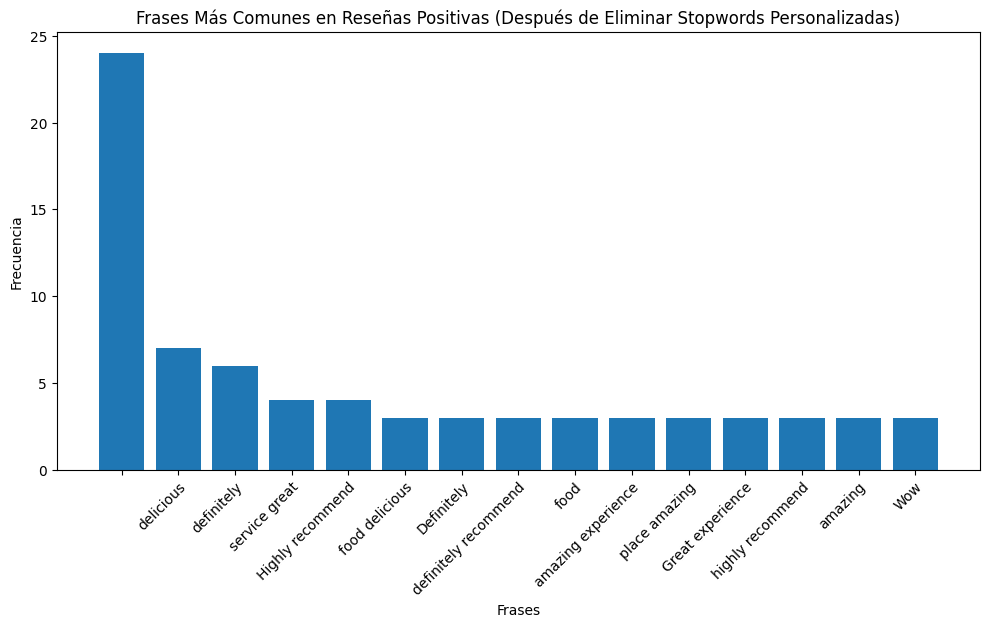

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

# Definimos una lista de stopwords personalizada
custom_stopwords = list(ENGLISH_STOP_WORDS) + ['the', 'it', 'is', 'and', 'i', 'you']  # Agrega aquí las palabras que deseas eliminar

# Función para limpiar y dividir el texto en frases
def split_into_sentences(text):
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

# Tokenizamos las reseñas para obtener frases
positive_reviews['sentences'] = positive_reviews['text'].apply(split_into_sentences)

# Función para eliminar las stopwords personalizadas y obtener frases limpias
def remove_stopwords_and_clean(sentences):
    cleaned_sentences = []
    for sentence in sentences:
        words = sentence.split()
        cleaned_words = [word for word in words if word.lower() not in custom_stopwords]
        cleaned_sentence = ' '.join(cleaned_words)
        cleaned_sentences.append(cleaned_sentence)
    return cleaned_sentences

# Eliminamos las stopwords personalizadas y limpiamos las frases
positive_reviews['cleaned_sentences'] = positive_reviews['sentences'].apply(remove_stopwords_and_clean)

# Contamos las frecuencias de las frases limpias
sentence_counts = Counter(sentence for review in positive_reviews['cleaned_sentences'] for sentence in review)

# Las frases más comunes en las reseñas positivas después de eliminar stopwords personalizadas
most_common_sentences = sentence_counts.most_common(15)  # Puedes ajustar el número de frases mostradas

# Extraemos las frases y sus frecuencias
sentences, frequencies = zip(*most_common_sentences)

# Creamos una visualización de barras para las frases más comunes
plt.figure(figsize=(10, 6))
plt.bar(sentences, frequencies)
plt.xticks(rotation=45, wrap=True, ha='right')
plt.xlabel('Frases')
plt.ylabel('Frecuencia')
plt.title('Frases Más Comunes en Reseñas Positivas (Después de Eliminar Stopwords Personalizadas)')
plt.tight_layout()
plt.show()

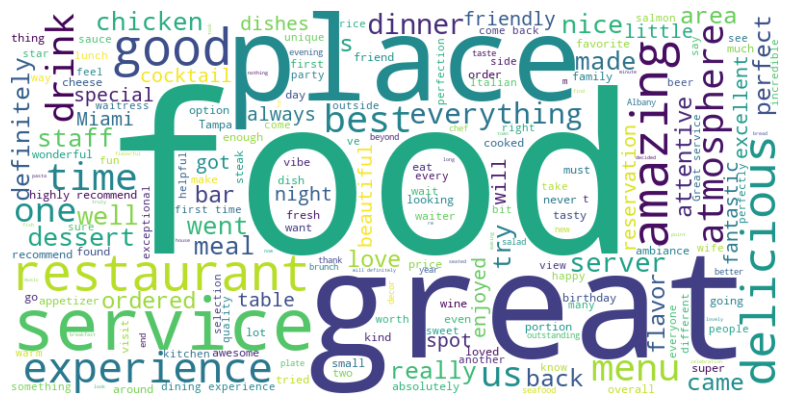

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenamos todas las reseñas en un solo texto
all_text = ' '.join(positive_reviews['text'])

# Creamos el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Mostramos el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
# Seleccionamos ejemplos para cada tema (puedes ajustar estos índices según tus necesidades)
comida_examples = [1, 4]  # Índices de las reseñas para el tema "comida"
servicio_examples = [2, 5]  # Índices de las reseñas para el tema "servicio"
ambiente_examples = [6, 8]  # Índices de las reseñas para el tema "ambiente"

# Agregamos una columna "tema" al DataFrame y asignamos los valores correspondientes
positive_reviews['tema'] = 'otros'  # Inicializamos con "otros" para las reseñas no etiquetadas
positive_reviews.loc[comida_examples, 'tema'] = 'comida'
positive_reviews.loc[servicio_examples, 'tema'] = 'servicio'
positive_reviews.loc[ambiente_examples, 'tema'] = 'ambiente'

# Mostramos el DataFrame con la columna de temas agregada
print(positive_reviews[['text', 'tema']])

                                                  text      tema
1    This is my first time at this first watch\nThe...    comida
2    After a 5 hour red-eye flight, I just wanted t...  servicio
4    The Italian food actually tastes Italian and n...    comida
5    Small place, with a dining area tucked back be...  servicio
6    Delicious!! We got ramen bowl and a rice dish,...  ambiente
..                                                 ...       ...
495  Came here on a weekday evening and the restaur...     otros
496  Red's place has a great tap list, and very sol...     otros
497  a good place to get a solid burger. Beer is go...     otros
498  Stopped by Red's along our road trip with our ...     otros
499  Having been here a few times for breakfast I'v...     otros

[456 rows x 2 columns]


In [9]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer

# Cargamos el modelo BERT pre-entrenado para la clasificación de secuencias
model_name = 'bert-base-uncased'
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Compilamos el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Mostramos un resumen del modelo
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
